In [1]:
import polars as pl

# Load dataset
data = pl.read_csv('csic_database.csv')

# Drop unnecessary columns
if "Unnamed: 0" in data.columns:
    data = data.drop("Unnamed: 0")

# Visualize remaining columns
print("Remaining Columns:", data.columns)

Remaining Columns: ['', 'Method', 'User-Agent', 'Pragma', 'Cache-Control', 'Accept', 'Accept-encoding', 'Accept-charset', 'language', 'host', 'cookie', 'content-type', 'connection', 'lenght', 'content', 'classification', 'URL']


In [2]:
# Rename incorrect column names
data = data.rename({"lenght": "length"})

# Visualize renamed columns
print("Renamed Columns:", data.columns)

Renamed Columns: ['', 'Method', 'User-Agent', 'Pragma', 'Cache-Control', 'Accept', 'Accept-encoding', 'Accept-charset', 'language', 'host', 'cookie', 'content-type', 'connection', 'length', 'content', 'classification', 'URL']


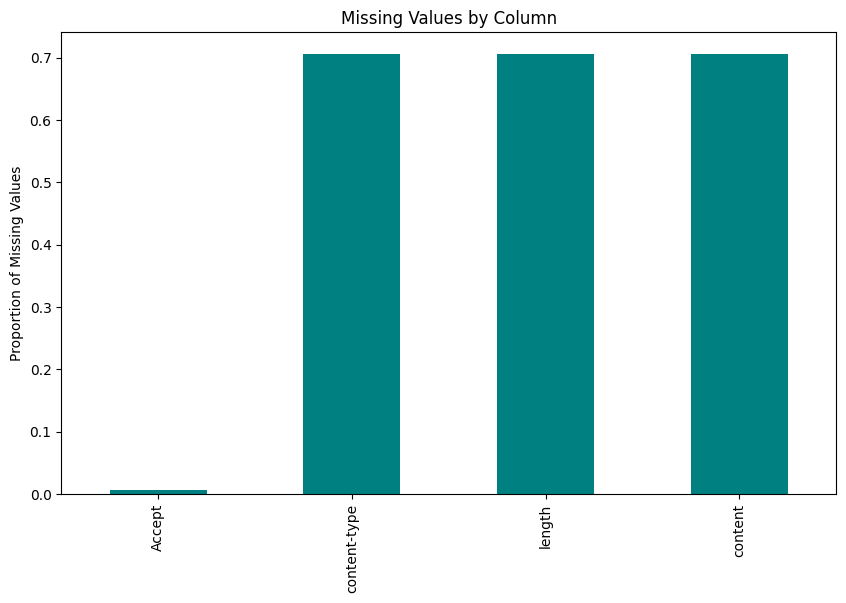

In [3]:
import matplotlib.pyplot as plt

# Convert to pandas for visualization
missing_df = data.to_pandas().isnull().mean()

# Plot missing values
plt.figure(figsize=(10, 6))
missing_df[missing_df > 0].plot(kind="bar", color="teal")
plt.title("Missing Values by Column")
plt.ylabel("Proportion of Missing Values")
plt.show()

In [4]:
# Calculate missing values ratio
missing_ratio = (data.null_count() / data.height).to_dict(as_series=False)

# Drop columns with >50% missing values
missing_threshold = 0.5
columns_to_drop = [col for col, ratio in missing_ratio.items() if ratio[0] > missing_threshold]

print(f"Dropping columns with >50% missing values: {columns_to_drop}")
data = data.drop(columns_to_drop)

# Impute missing values for categorical columns
categorical_cols = [col for col in data.columns if data[col].dtype == pl.Utf8]
numerical_cols = [col for col in data.columns if data[col].dtype in [pl.Int64, pl.Float64]]

# Fill missing values
for col in categorical_cols:
    if data[col].null_count() > 0:
        mode_value = data[col].mode().to_numpy()[0]  # Get mode as a plain value
        data = data.with_columns([data[col].fill_null(mode_value).alias(col)])

for col in numerical_cols:
    if data[col].null_count() > 0:
        median_value = data[col].median()  # Median is directly supported by Polars
        data = data.with_columns([data[col].fill_null(median_value).alias(col)])

# Re-check missing values
print("Missing Values After Handling:")
print(data.null_count())

# Calculate number of unique values in each column
unique_counts = data.select([pl.col(col).n_unique().alias(col) for col in data.columns])

print("Number of unique values in each column:")
print(unique_counts)

Dropping columns with >50% missing values: ['content-type', 'length', 'content']
Missing Values After Handling:
shape: (1, 14)
┌─────┬────────┬────────────┬────────┬───┬────────┬────────────┬────────────────┬─────┐
│     ┆ Method ┆ User-Agent ┆ Pragma ┆ … ┆ cookie ┆ connection ┆ classification ┆ URL │
│ --- ┆ ---    ┆ ---        ┆ ---    ┆   ┆ ---    ┆ ---        ┆ ---            ┆ --- │
│ u32 ┆ u32    ┆ u32        ┆ u32    ┆   ┆ u32    ┆ u32        ┆ u32            ┆ u32 │
╞═════╪════════╪════════════╪════════╪═══╪════════╪════════════╪════════════════╪═════╡
│ 0   ┆ 0      ┆ 0          ┆ 0      ┆ … ┆ 0      ┆ 0          ┆ 0              ┆ 0   │
└─────┴────────┴────────────┴────────┴───┴────────┴────────────┴────────────────┴─────┘
Number of unique values in each column:
shape: (1, 14)
┌─────┬────────┬────────────┬────────┬───┬────────┬────────────┬────────────────┬───────┐
│     ┆ Method ┆ User-Agent ┆ Pragma ┆ … ┆ cookie ┆ connection ┆ classification ┆ URL   │
│ --- ┆ ---    ┆ ---  

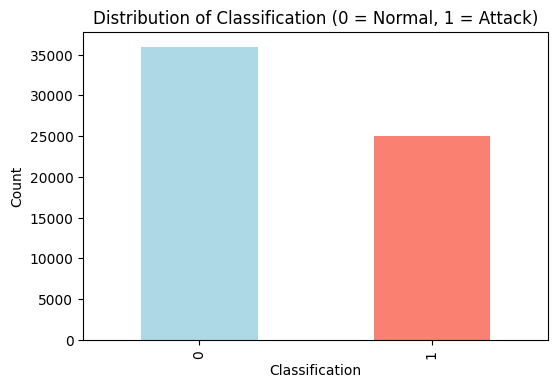

In [14]:
# Convert classification column to pandas for visualization
classification_counts = data["classification"].to_pandas().value_counts()

# Plot distribution
plt.figure(figsize=(6, 4))
classification_counts.plot(kind="bar", color=["lightblue", "salmon"])
plt.title("Distribution of Classification (0 = Normal, 1 = Attack)")
plt.xlabel("Classification")
plt.ylabel("Count")
plt.show()

In [5]:
# Save cleaned dataset
data.write_csv('cleaned_csic_database.csv')
print("Cleaned dataset saved as 'cleaned_csic_database.csv'.")

Cleaned dataset saved as 'cleaned_csic_database.csv'.


In [6]:
import polars as pl

# Load cleaned dataset with header
cleaned_data = pl.read_csv('cleaned_csic_database.csv', has_header=True)

# Drop the unnamed first column if it exists
if cleaned_data.columns[0] == "":
    cleaned_data = cleaned_data.drop(cleaned_data.columns[0])

# Display the first few rows of the cleaned data
print(cleaned_data.head())

shape: (5, 13)
┌────────┬────────────┬──────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ Method ┆ User-Agent ┆ Pragma   ┆ Cache-Cont ┆ … ┆ cookie     ┆ connectio ┆ classific ┆ URL       │
│ ---    ┆ ---        ┆ ---      ┆ rol        ┆   ┆ ---        ┆ n         ┆ ation     ┆ ---       │
│ str    ┆ str        ┆ str      ┆ ---        ┆   ┆ str        ┆ ---       ┆ ---       ┆ str       │
│        ┆            ┆          ┆ str        ┆   ┆            ┆ str       ┆ i64       ┆           │
╞════════╪════════════╪══════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ GET    ┆ Mozilla/5. ┆ no-cache ┆ no-cache   ┆ … ┆ JSESSIONID ┆ close     ┆ 0         ┆ http://lo │
│        ┆ 0 (compati ┆          ┆            ┆   ┆ =1F767F172 ┆           ┆           ┆ calhost:8 │
│        ┆ ble;       ┆          ┆            ┆   ┆ 39C9B670A3 ┆           ┆           ┆ 080/tiend │
│        ┆ Konqu…     ┆          ┆            ┆   ┆ …          ┆           ┆

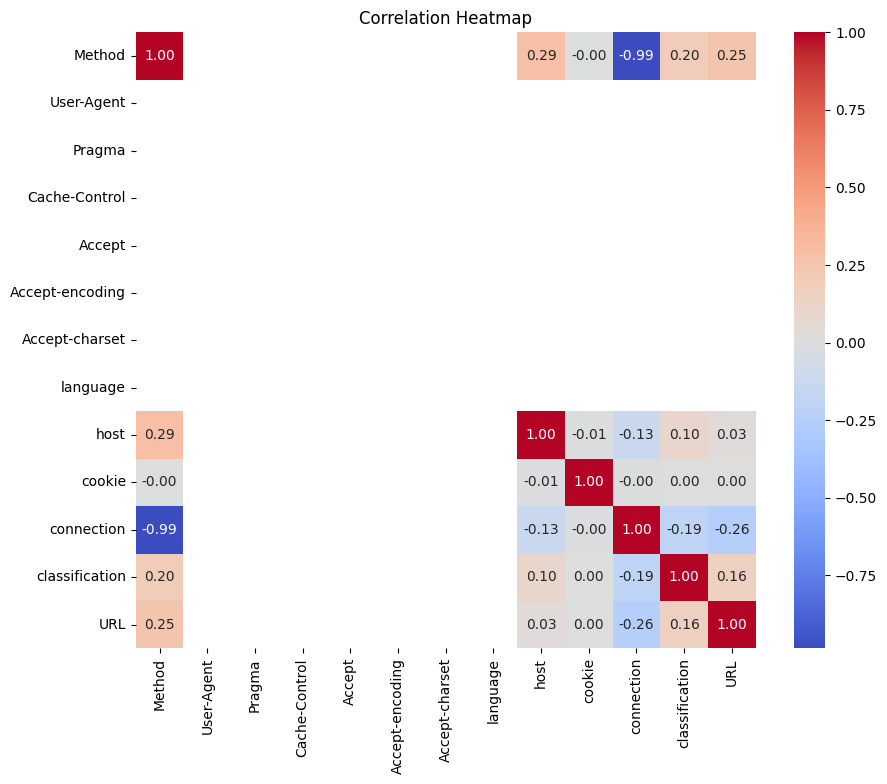

Correlations with classification:
classification     1.000000
Method             0.199492
URL                0.161084
host               0.096947
cookie             0.001923
connection        -0.189768
User-Agent              NaN
Pragma                  NaN
Cache-Control           NaN
Accept                  NaN
Accept-encoding         NaN
Accept-charset          NaN
language                NaN
Name: classification, dtype: float64


In [7]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Step 1: Temporary Encoding for Categorical Columns
categorical_cols = [col for col in cleaned_data.columns if cleaned_data[col].dtype == pl.Utf8]
label_encoders = {
    col: LabelEncoder().fit(cleaned_data[col].to_pandas()) for col in categorical_cols
}

# Create encoded dataset
encoded_data = cleaned_data.with_columns(
    [pl.Series(name=col, values=label_encoders[col].transform(cleaned_data[col].to_pandas())).alias(col) 
     for col in categorical_cols]
)

# Step 2: Select Numerical + Encoded Columns
numerical_cols = [col for col in encoded_data.columns if encoded_data[col].dtype in [pl.Int64, pl.Float64]]

# Step 3: Compute Correlation Matrix
correlation_matrix = encoded_data.select(numerical_cols).to_pandas().corr()

# Step 4: Visualize Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# Step 5: Identify Strong Correlations with Target Column
target_col = "classification"  # Replace with your actual target column
if target_col in numerical_cols:
    correlations_with_target = correlation_matrix[target_col].sort_values(ascending=False)
    print(f"Correlations with {target_col}:")
    print(correlations_with_target)
else:
    raise ValueError(f"Target column '{target_col}' is not in numerical columns!")


In [8]:
# Manually select columns based on correlation analysis
selected_columns = ["Method", "host", "cookie", "connection", "classification", "URL"]

# Filter the dataset to keep only selected columns
filtered_data = encoded_data.select(selected_columns)

print(f"Selected Columns: {filtered_data.columns}")


Selected Columns: ['Method', 'host', 'cookie', 'connection', 'classification', 'URL']


In [9]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Identify categorical columns (textual data)
categorical_cols = [col for col in filtered_data.columns if filtered_data[col].dtype == pl.Utf8]

# Check if there are any categorical columns to encode
if categorical_cols:
    # Apply One-Hot Encoding for categorical columns
    one_hot_encoder = OneHotEncoder(sparse_output=False, drop="first")
    encoded_categorical = one_hot_encoder.fit_transform(filtered_data[categorical_cols].to_pandas())

    # Combine One-Hot Encoded data with numerical columns
    numerical_cols = [col for col in filtered_data.columns if col not in categorical_cols]
    encoded_df = pd.concat(
        [pd.DataFrame(encoded_categorical, columns=one_hot_encoder.get_feature_names_out(categorical_cols)),
         filtered_data[numerical_cols].to_pandas().reset_index(drop=True)],
        axis=1
    )

    print("Shape of encoded dataset:", encoded_df.shape)
    print(f"Encoded columns: {one_hot_encoder.get_feature_names_out(categorical_cols)}")
else:
    # No categorical columns detected
    encoded_df = filtered_data.to_pandas()  # Simply convert to pandas if no encoding is needed
    print("No categorical columns to encode.")

# Display the first few rows of the encoded dataset
print(encoded_df.head())


No categorical columns to encode.
   Method  host  cookie  connection  classification   URL
0       0     0    7623           1               0   800
1       0     0   31127           1               0  5503
2       1     0   35218           0               0  3578
3       0     0   34368           1               0  6381
4       1     0   27185           0               0  5840


In [ ]:
# Filter the dataset to keep only categorical columns
categorical_data = data.select(categorical_cols)

print(f"Selected Categorical Columns: {categorical_data.columns}")
print(categorical_data.head())

In [ ]:
# Define the dataset path
dataset_path = 'cleaned_csic_database.csv'

# Load cleaned dataset with header
cleaned_data = pl.read_csv(dataset_path, has_header=True)

# Drop the unnamed first column if it exists
if cleaned_data.columns[0] == "":
    cleaned_data = cleaned_data.drop(cleaned_data.columns[0])

# Display the first few rows of the cleaned data
print(cleaned_data.head())

# Convert Polars DataFrame to pandas DataFrame
data_pandas = cleaned_data.to_pandas()

# Get the structure of the dataset
data_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61065 entries, 0 to 61064
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0                    61065 non-null  object
 1   Method           61065 non-null  object
 2   User-Agent       61065 non-null  object
 3   Pragma           61065 non-null  object
 4   Cache-Control    61065 non-null  object
 5   Accept           61065 non-null  object
 6   Accept-encoding  61065 non-null  object
 7   Accept-charset   61065 non-null  object
 8   language         61065 non-null  object
 9   host             61065 non-null  object
 10  cookie           61065 non-null  object
 11  connection       61065 non-null  object
 12  classification   61065 non-null  int64 
 13  URL              61065 non-null  object
dtypes: int64(1), object(13)
memory usage: 6.5+ MB
